<a href="https://colab.research.google.com/github/javsec/repositorio/blob/main/simpsons_is_homer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.0 MB/s 


In [4]:




from spellchecker import SpellChecker

import re  # Procesamiento de Texto
import pandas as pd 
from time import time  # Medir tiempo de ejecucion
import multiprocessing
import logging # Sacar logs del Modelo

import numpy as np 
%matplotlib inline

from collections import defaultdict  
from sklearn.model_selection import train_test_split
import nltk
# from spellchecker import SpellChecker
import spacy  # Procesamiento NLP

import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración matplotlib
# ==============================================================================

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
     


In [6]:
# cargamos datos 

url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/simpson_dataset.csv'
df = pd.read_csv(url)
df.tail() # Ultimas filas





,raw_character_text,spoken_words
158309,Miss Hoover,I'm back.
158310,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
158311,Miss Hoover,Psy-cho-so-ma-tic.
158312,Ralph Wiggum,Does that mean you were crazy?
158313,JANEY,"No, that means she was faking it."


In [7]:
#Verifico si existen Nam
print('Verifico nulos ',df.isnull().sum())


Verifico nulos  raw_character_text    17814
spoken_words          26459
dtype: int64


In [8]:
#Borro Nulls
df = df.dropna().reset_index(drop=True) # Eliminar nulos

In [93]:
#df['is_homer'] = [
#  1  if x.lower().count("homer")  else 0 
#      for x in df.raw_character_text.values
#]

In [9]:
valores = ["Homer Simpson", "Young Homer", "Homer's Brain","Homer's Thoughts" ]

df['is_homer'] = [
  1  if x in valores 
  else  0 
      for x in df.raw_character_text.values
]

In [10]:
print ("distribucion",df.is_homer.value_counts()/len(df))

distribucion 0    0.787081
1    0.212919
Name: is_homer, dtype: float64


In [11]:
cumsum_participation = df.raw_character_text.value_counts().cumsum()
mask = cumsum_participation <= 110_000
rel_characters = cumsum_participation[mask].index
# Filter for the relevant characters
df = df[df.raw_character_text.isin(rel_characters)]

In [12]:
# reducimos a la 50% de los not homer
# Esto también nos ayudará a balancear el modelo
sample_size = int(
     len(
         df.query(
            "is_homer == 0"
        )
    ) * 0.5
)
to_model_df = df.query(
    "is_homer == 1"
).append(
    df.query(
        "is_homer == 0"
).sample(sample_size)
).reset_index(drop=True)

# Finalmente, recomiendo entrenar con un dataset más pequeño para evitar
# problemas de memoria

to_model_sample_size = 20_000  # pueden incluso disminuir este valor
to_model_df = to_model_df.sample(to_model_sample_size)

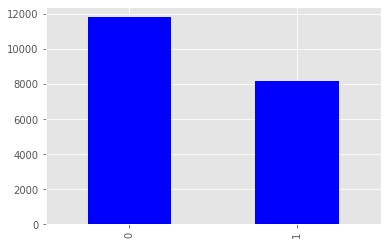

In [14]:
to_model_df.is_homer.value_counts().plot(kind="bar",color='blue')

In [98]:
# Cargamos los métodos de Spacy en Ingles 
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # Quitamos el Named Entity Recognition por facilidad de procesamiento



In [18]:
nlp = spacy.load(
  'en_core_web_sm',  # Capaz sea necesario descargar modelo de Spacy English.
  disable=['ner', 'parser']  # desactivamos modelos por facilidad de procesamiento
  ) 

def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  txt = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec usa el contexto para entender la reperesentacion de la palabra
  # Si la oracion es corta, no va a aprender mucho
  if len(txt) > 2:
      return ' '.join(txt)
# Reemplazamos todo lo que no sea alphanum por espacio
brief_cleaning = (
  re.sub(r"[^A-Za-z0-9']+", 
  ' ', 
  str(row)).lower().strip() for row in to_model_df['spoken_words']  # por cada fila en df.
  )

In [19]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [
    cleaning(doc) for doc in nlp.pipe(
        brief_cleaning, # función que def antes
        batch_size=5000, 
        n_process=-1 # usamos todos los cores
    )
]
# medimos tiempo de ejecución 
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.59 mins


In [20]:
to_model_df['clean_txt'] = txt
to_model_df.tail()

,raw_character_text,spoken_words,is_homer,clean_txt
61479,Marge Simpson,"Oh, Homie, I don't care if you're a billionair...",0,oh homie care billionaire love
47475,Krusty the Clown,"Naw, this is somethin' else. So, uh... where i...",0,naw something uh hot air
54837,Marge Simpson,I guess we have to move on.,0,None
26499,Homer Simpson,"Oh, well, I don't know. Would it be alright if...",1,oh know alright confer family
22775,Homer Simpson,A pity kiss?! That tears it! I'm gonna call th...,1,pity kiss tear go to paula paul piece mind


In [21]:
#Borro Nulls
to_model_df = to_model_df.dropna().reset_index(drop=True) # Eliminar nulos

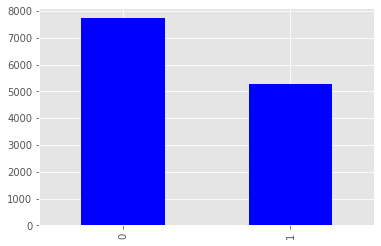

In [22]:
to_model_df.is_homer.value_counts().plot(kind="bar",color='blue')

In [25]:
def generar_Wordcloud(texto,titulo):
  wordcloud = WordCloud(width=5000,height=3000).generate(texto)
  plt.figure(figsize=(12,12))
  plt.title(titulo)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

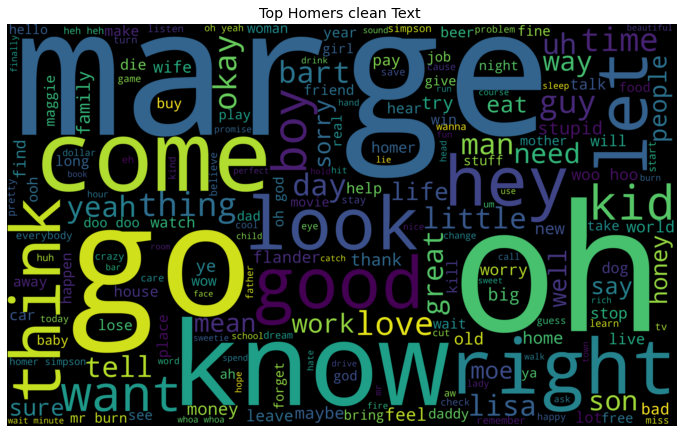

In [27]:
txt_homer = to_model_df[to_model_df['is_homer']==1]
most_words_homer = " ".join(txt_homer['clean_txt'])

generar_Wordcloud(most_words_homer,'Top Homer''s clean Text ')

In [28]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [29]:
to_model_df.head()

,raw_character_text,spoken_words,is_homer,clean_txt
0,Homer Simpson,"Split up?! Marge, no! We can fix this marriage!",1,split marge fix marriage
1,Homer Simpson,I also want my boy to find out that you're mor...,1,want boy find belly want meet woman spangle gl...
2,Homer Simpson,With that painting we could have what these pe...,1,painting people money cushion live paycheck pa...
3,Bart Simpson,Says here they throw salt before they wrestle ...,0,say throw salt wrestle purify ring
4,Homer Simpson,"The sad part is, there were times when I actua...",1,sad time actually feeling feel father


In [31]:
TARGET = "is_homer"
X = to_model_df['clean_txt']
y = to_model_df[TARGET]
# Dividimos entre set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

In [32]:
# Creamos el Sklearn Pipeline con todas las transformaciones mencionadas arriba 
text_clf_rf = Pipeline([
  ('vect', CountVectorizer()), 
  ('tfidf', TfidfTransformer()), # transforma por frecuencia 
  ('clf_rf', RandomForestClassifier(n_estimators=100, 
                                    verbose=True, # Verbose -> barra progreso
    oob_score=True,min_samples_split=2))
               ])
# Realizamos un entrenamiento con CV para tener certeza de los resultados
# Y también poder probar cuál modelo es el mejor. 

scoring = "f1_micro" # metric to optimize can be 'recall'
cv = 3 # cross validation
parameters = { 
  'vect__ngram_range': [(1, 1), (1, 2)],
  'tfidf__use_idf': (True, False),
  'clf_rf__n_estimators': (200, 400),
  'clf_rf__min_samples_split': (2,4)
}

# Creamos todo el pipeline para que ademas ejecute cambio de parametros 
grid = GridSearchCV(text_clf_rf, cv=cv, param_grid=parameters, 
                    scoring=scoring, n_jobs = -1)

In [34]:
from time import time  # Medir tiempo de ejecucion
t = time() # Calculamos tiempo
# Entrenamos 
grid.fit(X_train, y_train) # Tiempo de entrenamiento 

t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

# summarize results
print(f"Resultados en base a {scoring}")
print("Mejor: %f usando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Resultado medio: {mean}, SD: {stdev}  con: {param}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.3s finished


Tiempo de ejecución: 15.03 mins
Resultados en base a f1_micro
Mejor: 0.639155 usando {'clf_rf__min_samples_split': 4, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6356333223286014, SD: 0.003718883074439521  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.6315615714757346, SD: 0.003802608681230531  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6371739848134698, SD: 0.003887646469165972  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.6384945526576428, SD: 0.0027357330020151734  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.6350830857268626, SD: 0.003518073591536413  c

In [35]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished



accuracy 0.6426187419768935


              precision    recall  f1-score   support

           0       0.66      0.83      0.73      2318
           1       0.60      0.36      0.45      1577

    accuracy                           0.64      3895
   macro avg       0.63      0.60      0.59      3895
weighted avg       0.63      0.64      0.62      3895

Confusion matrix, without normalization


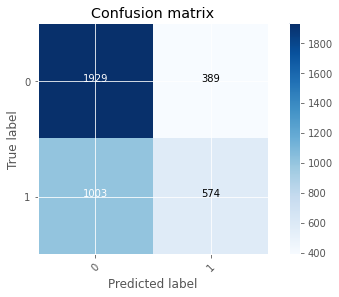

In [36]:
m_best = grid.best_estimator_ # mejor modelo
y_pred = m_best.predict(X_test)
# Metricas de precision
print('\naccuracy %s' % accuracy_score(y_pred, y_test))
print("\n")
print(classification_report(y_test, y_pred,))

# plot 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(2)))